<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2020/blob/master/Vision/SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download SVHN Train and Extra Datasets

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/extra.tar.gz
!tar -xzf extra.tar.gz

--2020-09-24 13:25:52--  http://ufldl.stanford.edu/housenumbers/extra.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1955489752 (1.8G) [application/x-gzip]
Saving to: ‘extra.tar.gz’

extra.tar.gz        100%[===================>]   1.82G  13.3MB/s    in 2m 17s  

2020-09-24 13:28:09 (13.6 MB/s) - ‘extra.tar.gz’ saved [1955489752/1955489752]



In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!tar -xzf train.tar.gz

--2020-09-24 12:12:30--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  20.1MB/s    in 22s     

2020-09-24 12:12:53 (17.4 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]



## Install Required packages

In [ ]:
!pip install fastai --upgrade -q

## Imports

In [ ]:
import h5py
import os
import tqdm
import pandas as pd


from fastai.data.all import *
from fastai.vision.all import *

## Functions to extract label data from file stored in  matlab format.

In [ ]:
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]]])


## Extract training labels

In [ ]:
mat_data = h5py.File(os.path.join('train/', 'digitStruct.mat'))
size = mat_data['/digitStruct/name'].size

train=[]
for _i in tqdm.tqdm(range(size)):
 train.append([get_name(_i, mat_data), get_box_data(_i, mat_data)['label']])

## Extract extra labels

In [ ]:
mat_data = h5py.File(os.path.join('extra/', 'digitStruct.mat'))
size = mat_data['/digitStruct/name'].size

extra=[]
for _i in tqdm.tqdm(range(size)):
 extra.append([get_name(_i, mat_data), get_box_data(_i, mat_data)['label']])

## Append folder names to respective files

In [67]:
for index,_ in enumerate(train):
  train[index][0]='train/'+train[index][0]

In [69]:
for index,_ in enumerate(extra):
  extra[index][0]='extra/'+extra[index][0]

In [106]:
train_df=pd.DataFrame(L(train)+L(extra))
train_df.columns=['filename','labels']
train_df.head()

,filename,labels
0,train/1.png,"[1, 9]"
1,train/2.png,"[2, 3]"
2,train/3.png,"[2, 5]"
3,train/4.png,"[9, 3]"
4,train/5.png,"[3, 1]"


In [107]:
#train_df.to_csv('train.csv')

In [108]:
train_df['labels']=pd.DataFrame([str(line).strip('[').strip(']').replace("'","").replace(",","") for line in train_df['labels']])
train_df.head()

,filename,labels
0,train/1.png,1 9
1,train/2.png,2 3
2,train/3.png,2 5
3,train/4.png,9 3
4,train/5.png,3 1


## Identify entries with decimal values.

In [ ]:
for i in train_df.values:
  if re.match(r"^[1-9].0", i[1]): print(i)

In [110]:
im = Image.open('extra/165154.png')
im.to_thumb(128,128)

## Remove decimal point and proceeding zero from the entries

In [111]:
train_df['labels']=pd.DataFrame([str(line).strip('.0') for line in train_df['labels']])

## Create functions, batch tranformations, DataBlock and Learner - FastAI

Every image is assigned with multiple labels, which translates this into a multi class classification problem.

Every Image is resized to 224 (item transformation) and bunch of transformation is applied to the every batch of the image.

The default values updated for aug_transforms looking at the problem at hand. Since the images are from door/gates, we have turned of the horzonta and vertical flip. 

There is high chance the inference/production images could be rotated, hence the max rotate is set at 180 so that enough augmentaed data is generated for such scenario.

The batch is normalized to ImageNet statistics, since the model I have used is ResNet50 pretrained on ImageNet Dataset.

The train, validation split is handled internally by the library at the ration of 80:20

In [123]:
def _svhm_items(x): return (x.filename, x.labels)

batch_tfms = [*aug_transforms(size=128,pad_mode='zeros', mult=2,flip_vert=False,do_flip=False,max_rotate=180,max_zoom=1.4),
              Normalize.from_stats(*imagenet_stats)]

svhn = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_svhm_items,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=batch_tfms)

In [124]:
#wafer.summary(train_df)

In [125]:
dls = svhn.dataloaders(train_df, bs=64)

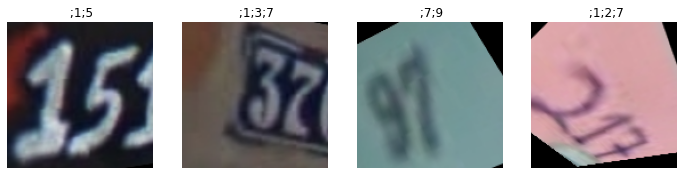

In [126]:
dls.train.show_batch(max_n=4, nrows=1)

In [127]:
learn = cnn_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.95)], 
                    pretrained=true,loss_func=BCEWithLogitsLossFlat(thresh=0.5))

> accuracy_multi is used to reflect the problem type at hand, ie., Multi Class Classification. 
Loss 

> Flattened BCEWithLogitsLoss is used a loss function to support Multiple Classes



In [128]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.402342,0.305362,0.793744,09:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.269051,0.122008,0.909610,10:12
1,0.224833,0.088760,0.939899,10:12
2,0.200937,0.073029,0.950837,10:11
3,0.192546,0.068777,0.957431,10:13


In [129]:
learn.save('svhn-9574')

Path('models/svhn-9574.pth')

## Inference

In [ ]:
!pip install -q gdown
!gdown --id 1l451BvbyBjWsUXEfzIEFyZ8DWTwZ8vTP

Downloading...
From: https://drive.google.com/uc?id=1l451BvbyBjWsUXEfzIEFyZ8DWTwZ8vTP
To: /content/testsvhn.zip
100% 852k/852k [00:00<00:00, 113MB/s]


In [130]:
!unzip testsvhn.zip

Archive:  testsvhn.zip
   creating: testsvhn/
  inflating: testsvhn/test1.png      
  inflating: testsvhn/test0.png      
  inflating: testsvhn/test2.png      
  inflating: testsvhn/test3.png      
  inflating: testsvhn/test4.png      
  inflating: testsvhn/test5.png      
  inflating: testsvhn/test6.png      
  inflating: testsvhn/test7.png      
  inflating: testsvhn/test8.png      
  inflating: testsvhn/test9.png      
  inflating: testsvhn/test10.png     
  inflating: testsvhn/test11.png     
  inflating: testsvhn/test12.png     
  inflating: testsvhn/test13.png     
  inflating: testsvhn/test14.png     
  inflating: testsvhn/test15.png     
  inflating: testsvhn/test16.png     
  inflating: testsvhn/test17.png     
  inflating: testsvhn/test18.png     
  inflating: testsvhn/test19.png     
  inflating: testsvhn/test20.png     
  inflating: testsvhn/test21.png     
  inflating: testsvhn/test22.png     
  inflating: testsvhn/test23.png     
  inflating: testsvhn/test24.png     
  in

(#100) [Path('testsvhn/test71.png'),Path('testsvhn/test62.png'),Path('testsvhn/test22.png'),Path('testsvhn/test3.png'),Path('testsvhn/test73.png'),Path('testsvhn/test44.png'),Path('testsvhn/test97.png'),Path('testsvhn/test23.png'),Path('testsvhn/test20.png'),Path('testsvhn/test74.png')...]

In [132]:
test_files = Path('./testsvhn').ls()
test_dl = learn.dls.test_dl(test_files, with_label=True)

In [133]:
prob,unk,preds = learn.get_preds(dl=test_dl, with_decoded=True)  

In [134]:
for index, item in enumerate(preds[:10]):
    print(list(dls.vocab[item]))

[' ', '2', '9']
[' ', '3']
[' ', '1', '2']
[' ', '1', '7']
['2']
[' ', '2', '4']
[' ', '2', '3']
[' ', '5', '6']
[' ', '2', '7']
[' ', '1', '3']


In [150]:
pred_vals=[]
for index, item in enumerate(preds): 
    prediction = list(dls.vocab[item])
    pred_vals.append(str(test_dl.items[index].name+'|'+str(prediction)))

In [159]:
final_df=pd.DataFrame(pred_vals,columns=['filename'])
final_df=final_df['filename'].str.split("|", n = 1, expand = True) #,columns=['filename','labels'])
final_df.columns=['filename','labels']
final_df

,filename,labels
0,test71.png,"[' ', '2', '9']"
1,test62.png,"[' ', '3']"
2,test22.png,"[' ', '1', '2']"
3,test3.png,"[' ', '1', '7']"
4,test73.png,['2']
...,...,...
95,test75.png,"[' ', '3', '6']"
96,test7.png,"[' ', '1', '7']"
97,test16.png,"[' ', '3', '7']"
98,test10.png,"[' ', '5', '8']"


In [160]:
final_df.to_csv('submission.csv')